In [1]:
# %% Imports

import numpy
import tensorflow as tf
from tensorflow import data
from keras import layers, datasets, utils, losses, metrics
import matplotlib.pyplot as pyplot
from tqdm import tqdm

from model import UNet

# Check for GPU
print(tf.config.list_physical_devices("GPU"))

WIDTH = 256
HEIGHT = 256
SIZE = (WIDTH, HEIGHT)
INPUTS_DIR = "datasets/validation/images/"
LABELS_DIR = "datasets/validation/segmentation/"
BATCH_SIZE = 1
SAVED_FILE = f"saved/v1/weights_{WIDTH}_{HEIGHT}.h5"

2023-12-06 17:42:40.068467: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 17:42:40.675295: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-12-06 17:42:42.034401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 17:42:42.083756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 17:42:42.083811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
seed = 100

input_images = utils.image_dataset_from_directory(
    INPUTS_DIR,
    labels=None,
    label_mode=None,
    image_size=SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    shuffle=False,
    seed=seed
)

input_images = input_images.cache()

label_images = utils.image_dataset_from_directory(
    LABELS_DIR,
    labels=None,
    label_mode=None,
    image_size=SIZE,
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    shuffle=False,
    seed=seed
)

label_images = label_images.cache()

Found 150 files belonging to 1 classes.


2023-12-06 17:42:45.335450: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 17:42:45.335637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 17:42:45.335682: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 17:42:45.574044: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 17:42:45.574117: I tensorflow/compile

Found 150 files belonging to 1 classes.


In [3]:
model = UNet()
model(layers.Input((WIDTH, HEIGHT, 3)))

<KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'u_net')>

In [4]:
model.load_weights(SAVED_FILE)

In [5]:
metric = metrics.BinaryIoU()
loss_list = []
for (inputs, labels) in tqdm(data.Dataset.zip((input_images, label_images))):
    labels = tf.cast(labels > 0.5, dtype="int8")
    outputs = model(inputs / 255)
    loss_value = metric(labels, outputs).numpy()
    loss_list.append(loss_value)
total_loss = numpy.average(loss_list)
print(f"Mean Itersect-over-Union: {total_loss}")

  0%|          | 0/150 [00:00<?, ?it/s]2023-12-06 17:42:49.813803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype string and shape [150]
	 [[{{node Placeholder/_12}}]]
2023-12-06 17:42:49.814051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype string and shape [150]
	 [[{{node Placeholder/_12}}]]
2023-12-06 17:42:50.035649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
100%|██████████| 150/150 [00:06<00:00, 23.34it/s]

Mean Itersect-over-Union: 0.6451185941696167


In [6]:
input_image = tf.keras.utils.load_img("datasets/validation/images/ISIC_0013561.jpg", target_size=SIZE, color_mode="rgb")
inputs = tf.keras.utils.img_to_array(input_image)
label_image = tf.keras.utils.load_img("datasets/validation/segmentation/ISIC_0013561_segmentation.png", target_size=SIZE, color_mode="grayscale")
labels = tf.keras.utils.img_to_array(label_image, dtype="int8")

In [7]:
outputs = model(inputs.reshape((1, WIDTH, HEIGHT, 3)) / 255)

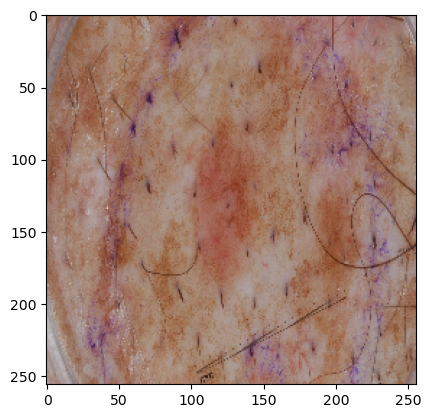

In [8]:
pyplot.imshow(input_image)

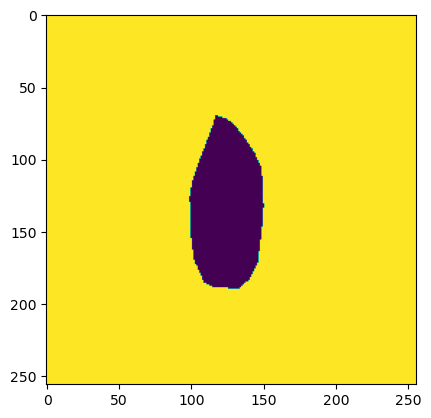

In [9]:
pyplot.imshow(labels)

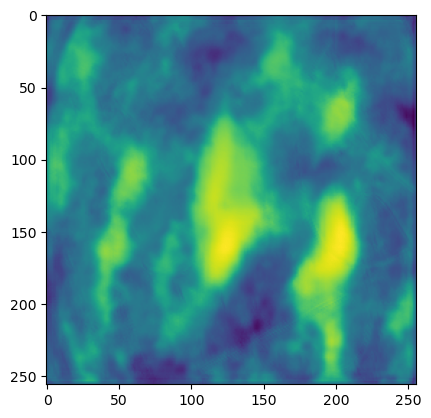

In [10]:
pyplot.imshow(outputs[0])

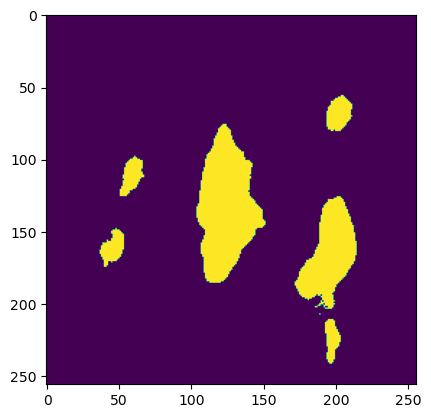

In [16]:
pyplot.imshow(outputs[0] > 0.75)

In [12]:
x1, s1 = model.encoder.block_1(inputs.reshape(1, WIDTH, HEIGHT, 3) / 255)
x2, s2 = model.encoder.block_2(x1)
x3, s3 = model.encoder.block_3(x2)
x4, _  = model.encoder.block_4(x3)

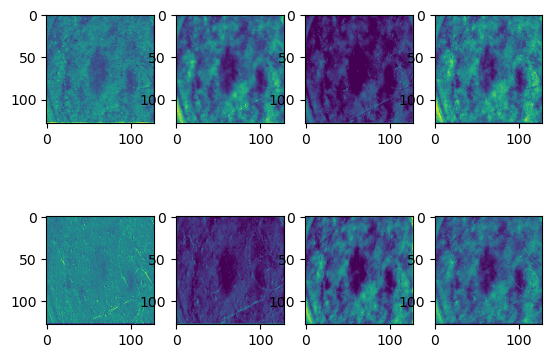

In [13]:
fig, axis = pyplot.subplots(2, 4)
for n in range(8):
    axis[n//4][n%4].imshow(x1[0, :, :, n])

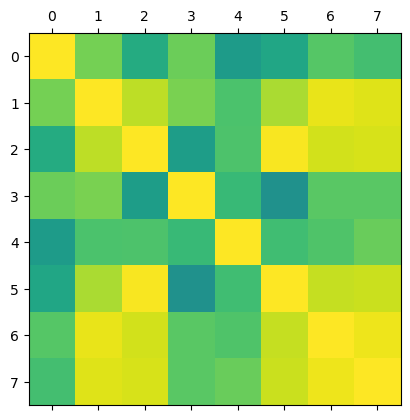

In [17]:
def get_cos_sim(size, x):
    cos_sim = numpy.ndarray((size, size))
    for i in range(size):
        for j in range(size):
            mat1 = x[0, :, :, i].numpy()
            mat1 = (mat1 * 2 - mat1.max()) / mat1.max()
            mat2 = x[0, :, :, j].numpy()
            mat2 = (mat2 * 2 - mat2.max()) / mat2.max()
            cos_sim[i][j] = numpy.sum(mat1 * mat2) / ( numpy.sqrt(numpy.sum(mat1**2)) * numpy.sqrt(numpy.sum(mat2**2)) )
    return cos_sim

cos_sim = get_cos_sim(8, x1)
pyplot.matshow(cos_sim, vmin=-1, vmax=1)

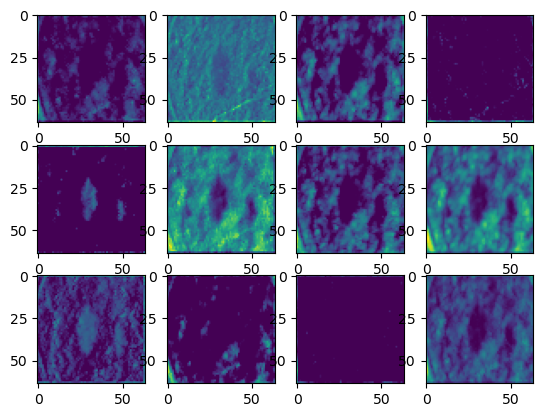

In [18]:
fig, axis = pyplot.subplots(3, 4)
for n in range(12):
    axis[n//4][n%4].imshow(x2[0, :, :, n])

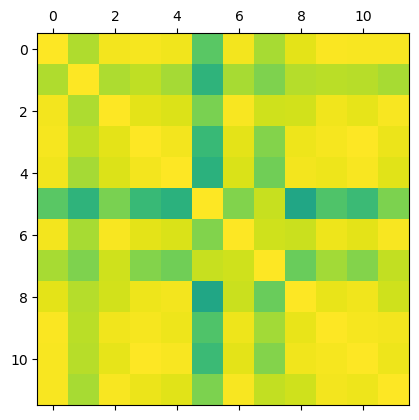

In [19]:
cos_sim = get_cos_sim(12, x2)
pyplot.matshow(cos_sim, vmin=-1, vmax=1)

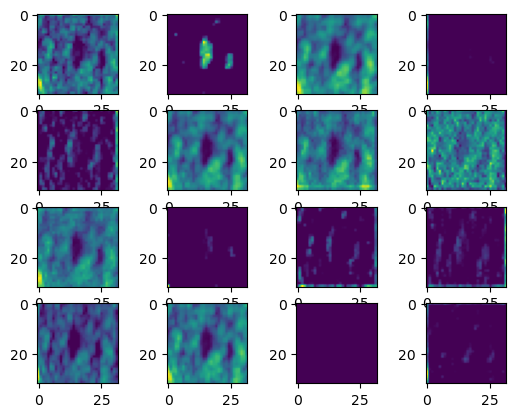

In [21]:
fig, axis = pyplot.subplots(4, 4)
for n in range(16):
    axis[n//4][n%4].imshow(x3[0, :, :, n])

/tmp/ipykernel_22351/3068333123.py:8: RuntimeWarning: invalid value encountered in divide
  mat2 = (mat2 * 2 - mat2.max()) / mat2.max()
/tmp/ipykernel_22351/3068333123.py:6: RuntimeWarning: invalid value encountered in divide
  mat1 = (mat1 * 2 - mat1.max()) / mat1.max()


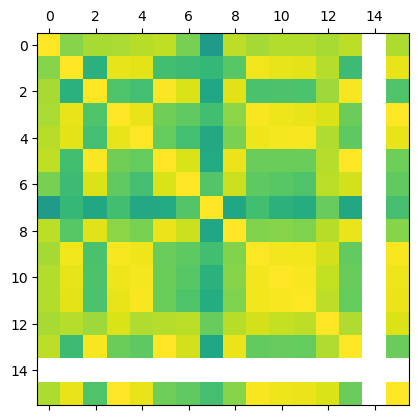

In [22]:
cos_sim = get_cos_sim(16, x3)
pyplot.matshow(cos_sim, vmin=-1, vmax=1)

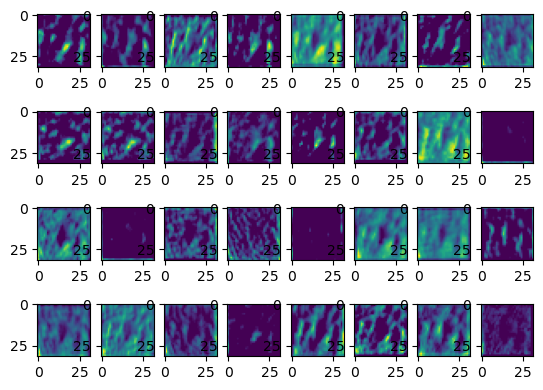

In [23]:
fig, axis = pyplot.subplots(4, 8)
for n in range(32):
    axis[n//8][n%8].imshow(x4[0, :, :, n])

/tmp/ipykernel_12321/3068333123.py:8: RuntimeWarning: invalid value encountered in divide
  mat2 = (mat2 * 2 - mat2.max()) / mat2.max()
/tmp/ipykernel_12321/3068333123.py:6: RuntimeWarning: invalid value encountered in divide
  mat1 = (mat1 * 2 - mat1.max()) / mat1.max()


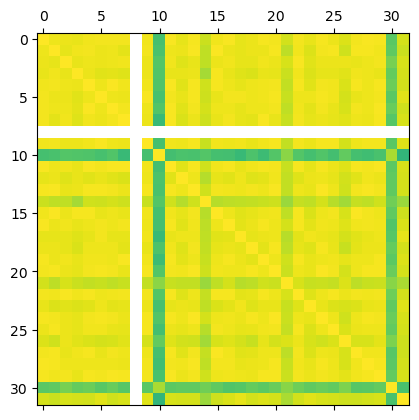

In [111]:
cos_sim = get_cos_sim(32, x4)
pyplot.matshow(cos_sim, vmin=-1, vmax=1)